# Multi class classification with CNN 

## Idea:
- Build a CNN model to classify the images of the fashion MNIST dataset.
- Use torchvision to build the model.

In [2]:
# import the necessary libraries
import torch 
from torchvision import datasets, transforms
from torch.utils.data import random_split
import numpy as np
import optuna
from optuna.trial import TrialState

/Users/thibtd/some fun/Deep-Learning/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1. Load and preprocess the dataset

In [3]:
transform_pipeline = transforms.ToTensor()

In [4]:
fashionMnist_data = datasets.FashionMNIST('./data',train=True,download=True, transform= transform_pipeline)

In [5]:
data_loader = torch.utils.data.DataLoader(fashionMnist_data,batch_size=1000, shuffle=True)

In [6]:
# Look at shape of the data
print(data_loader.dataset.data.shape)


torch.Size([60000, 28, 28])


In [7]:
# inspect type and range of data 
print(type(data_loader.dataset.data))
min_val = data_loader.dataset.data.min().item()
max_val = data_loader.dataset.data.max().item()
print(f'Range of data: {min_val} - {max_val}')


<class 'torch.Tensor'>
Range of data: 0 - 255


In [8]:
# Now let's normalize the data so that the pixel values are between 0 and 1
# Start by computing the mean and standard deviation of the dataset
mean = data_loader.dataset.data.float().mean() / max_val
std = data_loader.dataset.data.float().std() / max_val
print(f'Mean: {mean}, Std: {std}')

Mean: 0.28604060411453247, Std: 0.35302427411079407


In [9]:
# Now we can create a new transform pipeline that normalizes the data
transform_pipeline_final = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((mean.item(),), (std.item(),))
])
# Create a new dataset with the normalized data
fashionMnist_norm = datasets.FashionMNIST('./data', train=True, download=True, transform=transform_pipeline_final)

In [10]:
# create a new data loader
data_loader_final = torch.utils.data.DataLoader(fashionMnist_norm,batch_size=1000, shuffle=True)

In [11]:
print("Inspecting the actual transformed data from the DataLoader:")
input_shape = None
for images, labels in data_loader_final:
    # `images` here is the batch of data *after* all transforms have been applied
    input_shape = images.shape
    print(f"Shape of image batch: {input_shape}")
    print(f"Min pixel value (after ToTensor and Normalize): {images.min().item():.4f}")
    print(f"Max pixel value (after ToTensor and Normalize): {images.max().item():.4f}")
    print(f"Mean of first image in batch: {images[0].mean().item():.4f}")
    print(f"Std of first image in batch: {images[0].std().item():.4f}")
    break # Just look at the first batch

Inspecting the actual transformed data from the DataLoader:
Shape of image batch: torch.Size([1000, 1, 28, 28])
Min pixel value (after ToTensor and Normalize): -0.8103
Max pixel value (after ToTensor and Normalize): 2.0224
Mean of first image in batch: 0.0434
Std of first image in batch: 0.9084


In [12]:
number_classes = np.size(data_loader_final.dataset.classes)
input_shape[1]

1

### 2. Build the model

#### A simple CNN model
Conv -> ReLu -> Maxpool -> Conv -> ReLu  -> Maxpool -> Flatten -> Linear -> ReLu -> Linear 

*Bold parameter values are learnable and here serve for the explanation and as a start point.*

- input image is: (1,28,28). So each image has 1 channel and 28x28 pixels.  
- Conv layer will take the input image and apply a filter to it. The filter will slide over the image and produce a feature map.  
  we use *32* filters of size *3x3*, padding *1* and stride *1* ensure that the output size is the same as the input size.   
  Dimensions: (32,28,28)  
- Maxpool layer will take the feature map and reduce its size by taking the maximum value in each 2x2 block.  
    Kernel size controls the factor of the dimension reduction. A kernel size of *2* will reduce the size by a factor of 2.  
    Dimensions: (32,14,14)  
- Conv layer will take the feature map and apply a filter to it. The filter will slide over the image and produce a feature map.  
    we use *64* filters of size *3x3*, padding *1* and stride *1* ensure that the output size is the same as the input size.   
    Dimensions: (64,14,14)  
- Maxpool layer will take the feature map and reduce its size by taking the maximum value in each 2x2 block.  
    Dimensions: (64,7,7)    
(here we flatten the images but it's not included in the architecture)     
- Fully connected layer that takes the flattened features and processes them  
 Input size == Flattened size == 64*7*7 == 3136  
 Output size == *128*  
- Fully connected layer that takes the output of the previous layer and processes it  
 Input size == *128* (in the sense that the output of the previous layer is the input of this layer)   
 Output size == 10 (number of classes)  




In [13]:
28//4

7

In [14]:
class SimpleCNN(torch.nn.Module):
    def __init__(self,input_shape:torch.Tensor, num_classes:int,kernel_size:int=3, stride:int=1):
        super(SimpleCNN, self).__init__()
        padding = kernel_size // 2 if stride == 1 else 0
        max_pool_kernel = 2
        in_channel = input_shape[1]
        w,h = input_shape[2], input_shape[3]
        self.conv1 = torch.nn.Conv2d(in_channels=in_channel, out_channels=32, kernel_size=kernel_size, stride=1, padding=padding)
        self.maxpool1 = torch.nn.MaxPool2d(kernel_size=max_pool_kernel, stride=2)
        self.conv2 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=kernel_size, stride=1, padding=padding)
        self.maxpool2 = torch.nn.MaxPool2d(kernel_size=max_pool_kernel, stride=2)
        self.fc1 = torch.nn.Linear(in_features=64* (w//(2*max_pool_kernel))*(h//(2*max_pool_kernel)), out_features=128)
        self.fc2 = torch.nn.Linear(in_features=128, out_features=num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.nn.functional.relu(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = torch.nn.functional.relu(x)
        x = self.maxpool2(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = torch.nn.functional.relu(x)
        x = self.fc2(x)
        return x

        
        

### 3. Train the model 

Since we are dealing with a multi-class classification problem, we will use the CrossEntropyLoss function.
The CrossEntropyLoss function combines the softmax activation function and the negative log-likelihood loss function.
It uses logits directly and output the probabilities of each class. So we can see the output as a probability distribution over the classes.
Sensitive to class imbalance. --> we will check if we have any, if so we can use the class weights to balance the loss function.

For the optimzer, we will use the Adam optimizer. It is a popular choice for training deep learning models. It is an adaptive learning rate optimization algorithm that can be used instead of the classical stochastic gradient descent (SGD) method. Great starting point for most problems.


In [15]:
# Check if MPS is available
if torch.backends.mps.is_available():
    print("MPS (Metal Performance Shaders) is available! Using GPU.")
    device = torch.device("mps")
else:
    print("MPS is not available. Falling back to CPU.")
    device = torch.device("cpu")

MPS (Metal Performance Shaders) is available! Using GPU.


In [16]:
# check for class imbalance
data_loader_final.dataset.targets.bincount()

tensor([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000])

No imbalance in the dataset.

In [17]:
# instance of the model and send it to device
model = SimpleCNN(input_shape, number_classes)
model.to(device)

SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [18]:
# define loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [19]:
# train/val split 
train_size = int(0.8 * len(data_loader_final.dataset))
val_size = len(data_loader_final.dataset) - train_size
train_dataset, val_dataset = random_split(data_loader_final.dataset, [train_size, val_size])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)


In [20]:
#training parameters 
num_epochs = 5
train_loss = []
val_loss = []
train_acc = []
val_acc = []


In [30]:
# train the model 
def train_model(model, batch_size, num_epochs, lr):
    train_size = int(0.8 * len(data_loader_final.dataset))
    val_size = len(data_loader_final.dataset) - train_size
    train_dataset, val_dataset = random_split(data_loader_final.dataset, [train_size, val_size])
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = torch.nn.CrossEntropyLoss()
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    model.to(device)
    for epoch in range(num_epochs):
        # training phase 
        model.train()
        training_running_loss = 0.0
        training_running_correct = 0
        training_running_total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            
            training_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            training_running_total += labels.size(0)
            training_running_correct += (predicted == labels).sum().item()
        
        avg_epoch_loss = training_running_loss / len(train_loader)
        avg_epoch_acc = training_running_correct / training_running_total
        train_loss.append(avg_epoch_loss)
        train_acc.append(avg_epoch_acc)
        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_epoch_loss:.4f}, Training Accuracy: {avg_epoch_acc:.4f}")

        # validation phase
        model.eval()
        validation_running_loss = 0.0
        validation_running_correct = 0
        validation_running_total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = loss_fn(outputs, labels)
                
                validation_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                validation_running_total += labels.size(0)
                validation_running_correct += (predicted == labels).sum().item()
        validation_avg_epoch_loss = validation_running_loss / len(val_loader)
        validation_avg_epoch_acc = validation_running_correct / validation_running_total
        val_loss.append(validation_avg_epoch_loss)
        val_acc.append(validation_avg_epoch_acc)
        print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {validation_avg_epoch_loss:.4f}, Validation Accuracy: {validation_avg_epoch_acc:.4f}")
        print("-----------------------------------------------------")
    



### 4. Evaluate the model
- check the training and validation loss and accuracy. Overfitting?
- Check the accuracy of the model on the test set.

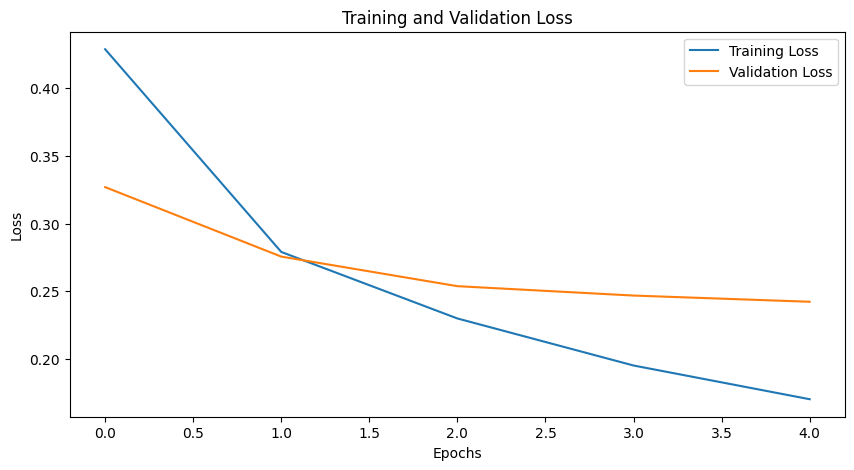

In [22]:
import matplotlib.pyplot as plt
fig1 = plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [23]:
test = datasets.FashionMNIST('./data', train=False, download=True, transform=transform_pipeline_final)
test_loader = torch.utils.data.DataLoader(test, batch_size=64, shuffle=False)

In [24]:
# test on the test set
test_running_loss = 0.0
test_running_correct = 0
test_running_total = 0

for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    loss = loss_fn(outputs, labels)
    test_running_loss += loss.item()
    test_running_total += labels.size(0)
    test_running_correct += (predicted == labels).sum().item()
    #print(f"Predicted: {predicted}, Actual: {labels}")
    
avg_test_loss = test_running_loss / len(test_loader)
avg_test_acc = test_running_correct / test_running_total
print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {avg_test_acc:.4f}")
print("-----------------------------------------------------")


Test Loss: 0.2555, Test Accuracy: 0.9114
-----------------------------------------------------


### 5. Hyperparameter tuning 
We use the Optuna library to tune the hyperparameters of the model.
- Batch size
- learning rate
- number of epochs
- optmizer

Architecture of the model:
- size of the kernels
- number of filters
- early stopping ? 

First will start with a simple study that will modify the hyperparameters outside of the model. We won't change the architecture of the model. 


In [25]:
# create a function to run the training and validation process 
def objective(trial,**args):
    # Define the hyperparameters 
    batch_size = trial.suggest_int('batch_size', 16,256,16)
    num_epochs= trial.suggest_int('num_epochs', 5,25,5)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)

    # Optimizer seems to have largest impact and Adam was generally better than SGD in preliminary tests. 
    #optimizer_trial = optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD"])
    

    #device setup 
    device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
    print(f"Trial {trial.number}: Using device: {device}, LR: {learning_rate:.6f}, Batch Size: {batch_size}, Epochs: {num_epochs}")

    # Load data and split into train and validation sets then create data loaders
    full_train_dataset = datasets.FashionMNIST('./data', train=True, download=True, transform=transform_pipeline_final)
    train_size = int(0.8 * len(full_train_dataset)) 
    val_size = len(full_train_dataset) - train_size

    train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    input_shape = None
    for images, labels in train_loader:
        input_shape = images.shape
        break

    number_classes = np.size(train_loader.dataset.dataset.classes)

    # Initialize the model
    model = SimpleCNN(input_shape, number_classes)
    model.to(device)

    # Define loss function and optimizer
    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    
    # train the model 
    best_val_accuracy = 0.0 # To track best performance for pruning
    for epoch in range(num_epochs):
        # Training Phase
        model.train()
        running_train_loss = 0.0
        correct_train_predictions = 0
        total_train_samples = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train_samples += labels.size(0)
            correct_train_predictions += (predicted == labels).sum().item()

        avg_train_loss = running_train_loss / len(train_loader)
        train_accuracy = 100 * correct_train_predictions / total_train_samples

        # Validation Phase
        model.eval()
        running_val_loss = 0.0
        correct_val_predictions = 0
        total_val_samples = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = loss_fn(outputs, labels)
                running_val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total_val_samples += labels.size(0)
                correct_val_predictions += (predicted == labels).sum().item()

        avg_val_loss = running_val_loss / len(val_loader)
        val_accuracy = 100 * correct_val_predictions / total_val_samples

        print(f"  Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Train Acc = {train_accuracy:.2f}% | Val Loss = {avg_val_loss:.4f}, Val Acc = {val_accuracy:.2f}%")

       
        best_val_accuracy = max(best_val_accuracy, val_accuracy)
        trial.report(val_accuracy, epoch)

        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return best_val_accuracy

    

In [26]:
db_storage_path = "sqlite:///fashion_mnist_hpo.db"

study = optuna.create_study(
    study_name="fashion_mnist_cnn_hpo_study",
    direction="maximize",
    storage=db_storage_path,
    load_if_exists=True,
)

print("\n--- Starting Optuna Hyperparameter Optimization ---")
study.optimize(objective, n_trials=20)

print("\n--- Optuna Optimization Finished ---")
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print(f"  Value: {trial.value:.4f} (Best Validation Accuracy)")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2025-05-26 14:19:07,817] Using an existing study with name 'fashion_mnist_cnn_hpo_study' instead of creating a new one.
/var/folders/07/cbtj5f0s2_v0hy9qt2t1zqgc0000gn/T/ipykernel_4421/1134657496.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int('batch_size', 16,256,16)
/var/folders/07/cbtj5f0s2_v0hy9qt2t1zqgc0000gn/T/ipykernel_4421/1134657496.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  num_epochs= trial.suggest_int('num_epochs', 5,25,5)



--- Starting Optuna Hyperparameter Optimization ---
Trial 20: Using device: mps, LR: 0.000719, Batch Size: 112, Epochs: 25
  Epoch 1: Train Loss = 0.5000, Train Acc = 82.17% | Val Loss = 0.3542, Val Acc = 87.55%
  Epoch 2: Train Loss = 0.3190, Train Acc = 88.41% | Val Loss = 0.2984, Val Acc = 89.42%
  Epoch 3: Train Loss = 0.2666, Train Acc = 90.39% | Val Loss = 0.2933, Val Acc = 89.22%
  Epoch 4: Train Loss = 0.2367, Train Acc = 91.41% | Val Loss = 0.2552, Val Acc = 90.88%
  Epoch 5: Train Loss = 0.2103, Train Acc = 92.37% | Val Loss = 0.2450, Val Acc = 91.21%
  Epoch 6: Train Loss = 0.1896, Train Acc = 93.04% | Val Loss = 0.2711, Val Acc = 89.90%
  Epoch 7: Train Loss = 0.1725, Train Acc = 93.71% | Val Loss = 0.2193, Val Acc = 92.15%
  Epoch 8: Train Loss = 0.1515, Train Acc = 94.44% | Val Loss = 0.2234, Val Acc = 92.11%
  Epoch 9: Train Loss = 0.1341, Train Acc = 95.07% | Val Loss = 0.2238, Val Acc = 92.22%
  Epoch 10: Train Loss = 0.1192, Train Acc = 95.65% | Val Loss = 0.2431, Va

[I 2025-05-26 14:22:59,727] Trial 20 finished with value: 92.225 and parameters: {'batch_size': 112, 'num_epochs': 25, 'learning_rate': 0.0007190466784194314}. Best is trial 20 with value: 92.225.


  Epoch 25: Train Loss = 0.0173, Train Acc = 99.42% | Val Loss = 0.4017, Val Acc = 91.62%
Trial 21: Using device: mps, LR: 0.001106, Batch Size: 112, Epochs: 25
  Epoch 1: Train Loss = 0.4639, Train Acc = 83.25% | Val Loss = 0.3202, Val Acc = 88.64%
  Epoch 2: Train Loss = 0.2958, Train Acc = 89.30% | Val Loss = 0.2773, Val Acc = 89.85%
  Epoch 3: Train Loss = 0.2516, Train Acc = 90.79% | Val Loss = 0.2612, Val Acc = 90.43%
  Epoch 4: Train Loss = 0.2181, Train Acc = 91.96% | Val Loss = 0.2334, Val Acc = 91.47%
  Epoch 5: Train Loss = 0.1941, Train Acc = 92.70% | Val Loss = 0.2250, Val Acc = 91.80%
  Epoch 6: Train Loss = 0.1731, Train Acc = 93.70% | Val Loss = 0.2251, Val Acc = 91.92%
  Epoch 7: Train Loss = 0.1495, Train Acc = 94.53% | Val Loss = 0.2341, Val Acc = 91.82%
  Epoch 8: Train Loss = 0.1336, Train Acc = 95.10% | Val Loss = 0.2390, Val Acc = 91.63%
  Epoch 9: Train Loss = 0.1165, Train Acc = 95.69% | Val Loss = 0.2410, Val Acc = 92.02%
  Epoch 10: Train Loss = 0.1015, Train

[I 2025-05-26 14:26:47,976] Trial 21 finished with value: 92.4 and parameters: {'batch_size': 112, 'num_epochs': 25, 'learning_rate': 0.0011060294840424371}. Best is trial 21 with value: 92.4.


  Epoch 25: Train Loss = 0.0230, Train Acc = 99.24% | Val Loss = 0.4483, Val Acc = 91.96%
Trial 22: Using device: mps, LR: 0.001627, Batch Size: 128, Epochs: 25
  Epoch 1: Train Loss = 0.4589, Train Acc = 83.52% | Val Loss = 0.3240, Val Acc = 88.23%
  Epoch 2: Train Loss = 0.2913, Train Acc = 89.13% | Val Loss = 0.2672, Val Acc = 90.03%
  Epoch 3: Train Loss = 0.2403, Train Acc = 91.17% | Val Loss = 0.2342, Val Acc = 91.52%
  Epoch 4: Train Loss = 0.2090, Train Acc = 92.29% | Val Loss = 0.2196, Val Acc = 92.14%
  Epoch 5: Train Loss = 0.1813, Train Acc = 93.14% | Val Loss = 0.2074, Val Acc = 92.57%
  Epoch 6: Train Loss = 0.1568, Train Acc = 94.15% | Val Loss = 0.2330, Val Acc = 91.68%
  Epoch 7: Train Loss = 0.1355, Train Acc = 94.93% | Val Loss = 0.2158, Val Acc = 92.68%
  Epoch 8: Train Loss = 0.1147, Train Acc = 95.71% | Val Loss = 0.2350, Val Acc = 92.06%
  Epoch 9: Train Loss = 0.0973, Train Acc = 96.38% | Val Loss = 0.2273, Val Acc = 92.73%
  Epoch 10: Train Loss = 0.0824, Train

[I 2025-05-26 14:30:23,849] Trial 22 finished with value: 92.73333333333333 and parameters: {'batch_size': 128, 'num_epochs': 25, 'learning_rate': 0.0016269594651740216}. Best is trial 22 with value: 92.73333333333333.


  Epoch 25: Train Loss = 0.0189, Train Acc = 99.35% | Val Loss = 0.5391, Val Acc = 92.12%
Trial 23: Using device: mps, LR: 0.002064, Batch Size: 144, Epochs: 25
  Epoch 1: Train Loss = 0.4564, Train Acc = 83.39% | Val Loss = 0.3431, Val Acc = 87.75%
  Epoch 2: Train Loss = 0.2790, Train Acc = 89.84% | Val Loss = 0.2604, Val Acc = 90.69%
  Epoch 3: Train Loss = 0.2304, Train Acc = 91.57% | Val Loss = 0.2425, Val Acc = 91.18%
  Epoch 4: Train Loss = 0.1978, Train Acc = 92.67% | Val Loss = 0.2455, Val Acc = 91.40%
  Epoch 5: Train Loss = 0.1719, Train Acc = 93.56% | Val Loss = 0.2308, Val Acc = 91.95%
  Epoch 6: Train Loss = 0.1474, Train Acc = 94.43% | Val Loss = 0.2370, Val Acc = 91.59%
  Epoch 7: Train Loss = 0.1264, Train Acc = 95.34% | Val Loss = 0.2474, Val Acc = 91.80%
  Epoch 8: Train Loss = 0.1105, Train Acc = 95.87% | Val Loss = 0.2536, Val Acc = 92.08%
  Epoch 9: Train Loss = 0.0930, Train Acc = 96.54% | Val Loss = 0.2747, Val Acc = 91.97%
  Epoch 10: Train Loss = 0.0807, Train

[I 2025-05-26 14:33:01,468] Trial 23 pruned. 


  Epoch 19: Train Loss = 0.0347, Train Acc = 98.76% | Val Loss = 0.4999, Val Acc = 91.54%
Trial 24: Using device: mps, LR: 0.001205, Batch Size: 112, Epochs: 25
  Epoch 1: Train Loss = 0.4565, Train Acc = 83.79% | Val Loss = 0.3581, Val Acc = 87.08%
  Epoch 2: Train Loss = 0.2960, Train Acc = 89.34% | Val Loss = 0.2787, Val Acc = 89.84%
  Epoch 3: Train Loss = 0.2480, Train Acc = 90.96% | Val Loss = 0.2507, Val Acc = 90.71%
  Epoch 4: Train Loss = 0.2156, Train Acc = 92.14% | Val Loss = 0.2591, Val Acc = 90.64%
  Epoch 5: Train Loss = 0.1896, Train Acc = 93.04% | Val Loss = 0.2308, Val Acc = 91.46%
  Epoch 6: Train Loss = 0.1651, Train Acc = 93.91% | Val Loss = 0.2370, Val Acc = 91.48%
  Epoch 7: Train Loss = 0.1458, Train Acc = 94.54% | Val Loss = 0.2325, Val Acc = 91.99%
  Epoch 8: Train Loss = 0.1274, Train Acc = 95.23% | Val Loss = 0.2527, Val Acc = 91.26%
  Epoch 9: Train Loss = 0.1099, Train Acc = 95.94% | Val Loss = 0.2449, Val Acc = 92.00%
  Epoch 10: Train Loss = 0.0944, Train

[I 2025-05-26 14:36:48,736] Trial 24 finished with value: 92.2 and parameters: {'batch_size': 112, 'num_epochs': 25, 'learning_rate': 0.001205060961851098}. Best is trial 22 with value: 92.73333333333333.


  Epoch 25: Train Loss = 0.0195, Train Acc = 99.30% | Val Loss = 0.4774, Val Acc = 91.94%
Trial 25: Using device: mps, LR: 0.009390, Batch Size: 176, Epochs: 20
  Epoch 1: Train Loss = 0.5375, Train Acc = 80.93% | Val Loss = 0.3752, Val Acc = 86.31%
  Epoch 2: Train Loss = 0.3401, Train Acc = 87.59% | Val Loss = 0.3312, Val Acc = 87.79%
  Epoch 3: Train Loss = 0.3066, Train Acc = 88.67% | Val Loss = 0.3178, Val Acc = 87.97%
  Epoch 4: Train Loss = 0.2864, Train Acc = 89.36% | Val Loss = 0.3131, Val Acc = 88.64%
  Epoch 5: Train Loss = 0.2723, Train Acc = 89.82% | Val Loss = 0.3046, Val Acc = 89.00%
  Epoch 6: Train Loss = 0.2618, Train Acc = 90.18% | Val Loss = 0.3012, Val Acc = 89.10%


[I 2025-05-26 14:37:44,773] Trial 25 pruned. 


  Epoch 7: Train Loss = 0.2564, Train Acc = 90.39% | Val Loss = 0.3218, Val Acc = 88.11%
Trial 26: Using device: mps, LR: 0.000613, Batch Size: 112, Epochs: 20
  Epoch 1: Train Loss = 0.5038, Train Acc = 82.11% | Val Loss = 0.3443, Val Acc = 87.66%
  Epoch 2: Train Loss = 0.3254, Train Acc = 88.24% | Val Loss = 0.3037, Val Acc = 89.18%
  Epoch 3: Train Loss = 0.2846, Train Acc = 89.70% | Val Loss = 0.2784, Val Acc = 90.22%
  Epoch 4: Train Loss = 0.2549, Train Acc = 90.77% | Val Loss = 0.2567, Val Acc = 90.62%
  Epoch 5: Train Loss = 0.2317, Train Acc = 91.54% | Val Loss = 0.2443, Val Acc = 91.26%
  Epoch 6: Train Loss = 0.2116, Train Acc = 92.30% | Val Loss = 0.2512, Val Acc = 91.03%
  Epoch 7: Train Loss = 0.1905, Train Acc = 92.91% | Val Loss = 0.2611, Val Acc = 90.50%
  Epoch 8: Train Loss = 0.1786, Train Acc = 93.44% | Val Loss = 0.2402, Val Acc = 91.38%
  Epoch 9: Train Loss = 0.1648, Train Acc = 93.97% | Val Loss = 0.2419, Val Acc = 91.29%
  Epoch 10: Train Loss = 0.1498, Train 

[I 2025-05-26 14:40:47,673] Trial 26 finished with value: 92.13333333333334 and parameters: {'batch_size': 112, 'num_epochs': 20, 'learning_rate': 0.0006126193155533825}. Best is trial 22 with value: 92.73333333333333.


  Epoch 20: Train Loss = 0.0447, Train Acc = 98.46% | Val Loss = 0.3158, Val Acc = 91.89%
Trial 27: Using device: mps, LR: 0.000226, Batch Size: 112, Epochs: 25
  Epoch 1: Train Loss = 0.6186, Train Acc = 78.94% | Val Loss = 0.4323, Val Acc = 85.01%
  Epoch 2: Train Loss = 0.3932, Train Acc = 85.94% | Val Loss = 0.3642, Val Acc = 86.95%
  Epoch 3: Train Loss = 0.3447, Train Acc = 87.78% | Val Loss = 0.3442, Val Acc = 87.91%
  Epoch 4: Train Loss = 0.3152, Train Acc = 88.86% | Val Loss = 0.3054, Val Acc = 89.47%
  Epoch 5: Train Loss = 0.2966, Train Acc = 89.47% | Val Loss = 0.3002, Val Acc = 89.58%
  Epoch 6: Train Loss = 0.2788, Train Acc = 89.94% | Val Loss = 0.2898, Val Acc = 89.60%
  Epoch 7: Train Loss = 0.2636, Train Acc = 90.44% | Val Loss = 0.2672, Val Acc = 90.34%
  Epoch 8: Train Loss = 0.2521, Train Acc = 90.83% | Val Loss = 0.2588, Val Acc = 90.78%
  Epoch 9: Train Loss = 0.2377, Train Acc = 91.30% | Val Loss = 0.2573, Val Acc = 90.91%
  Epoch 10: Train Loss = 0.2287, Train

[I 2025-05-26 14:44:34,884] Trial 27 finished with value: 92.46666666666667 and parameters: {'batch_size': 112, 'num_epochs': 25, 'learning_rate': 0.0002255114543930892}. Best is trial 22 with value: 92.73333333333333.


  Epoch 25: Train Loss = 0.1183, Train Acc = 95.79% | Val Loss = 0.2266, Val Acc = 92.26%
Trial 28: Using device: mps, LR: 0.000290, Batch Size: 240, Epochs: 20


[I 2025-05-26 14:44:42,625] Trial 28 pruned. 


  Epoch 1: Train Loss = 0.6795, Train Acc = 76.77% | Val Loss = 0.4824, Val Acc = 82.91%
Trial 29: Using device: mps, LR: 0.003788, Batch Size: 160, Epochs: 25
  Epoch 1: Train Loss = 0.4521, Train Acc = 83.61% | Val Loss = 0.3277, Val Acc = 88.23%
  Epoch 2: Train Loss = 0.2794, Train Acc = 89.76% | Val Loss = 0.2650, Val Acc = 90.29%
  Epoch 3: Train Loss = 0.2308, Train Acc = 91.54% | Val Loss = 0.2677, Val Acc = 90.36%
  Epoch 4: Train Loss = 0.1986, Train Acc = 92.55% | Val Loss = 0.2715, Val Acc = 90.33%
  Epoch 5: Train Loss = 0.1729, Train Acc = 93.47% | Val Loss = 0.2461, Val Acc = 91.23%
  Epoch 6: Train Loss = 0.1475, Train Acc = 94.41% | Val Loss = 0.2495, Val Acc = 91.75%
  Epoch 7: Train Loss = 0.1343, Train Acc = 94.92% | Val Loss = 0.2561, Val Acc = 91.67%
  Epoch 8: Train Loss = 0.1171, Train Acc = 95.52% | Val Loss = 0.2718, Val Acc = 91.51%
  Epoch 9: Train Loss = 0.1003, Train Acc = 96.28% | Val Loss = 0.3378, Val Acc = 90.75%
  Epoch 10: Train Loss = 0.0906, Train 

[I 2025-05-26 14:46:52,008] Trial 29 pruned. 


  Epoch 16: Train Loss = 0.0513, Train Acc = 98.19% | Val Loss = 0.4730, Val Acc = 91.15%
Trial 30: Using device: mps, LR: 0.000206, Batch Size: 192, Epochs: 20


[I 2025-05-26 14:47:00,873] Trial 30 pruned. 


  Epoch 1: Train Loss = 0.7224, Train Acc = 75.79% | Val Loss = 0.4817, Val Acc = 83.04%
Trial 31: Using device: mps, LR: 0.000780, Batch Size: 112, Epochs: 25
  Epoch 1: Train Loss = 0.4860, Train Acc = 82.50% | Val Loss = 0.3292, Val Acc = 88.27%
  Epoch 2: Train Loss = 0.3109, Train Acc = 88.72% | Val Loss = 0.2694, Val Acc = 90.51%
  Epoch 3: Train Loss = 0.2631, Train Acc = 90.38% | Val Loss = 0.2406, Val Acc = 91.56%
  Epoch 4: Train Loss = 0.2312, Train Acc = 91.55% | Val Loss = 0.2458, Val Acc = 91.40%
  Epoch 5: Train Loss = 0.2077, Train Acc = 92.44% | Val Loss = 0.2502, Val Acc = 90.78%
  Epoch 6: Train Loss = 0.1881, Train Acc = 93.07% | Val Loss = 0.2245, Val Acc = 91.90%
  Epoch 7: Train Loss = 0.1696, Train Acc = 93.80% | Val Loss = 0.2129, Val Acc = 92.39%
  Epoch 8: Train Loss = 0.1507, Train Acc = 94.59% | Val Loss = 0.2191, Val Acc = 92.35%
  Epoch 9: Train Loss = 0.1349, Train Acc = 95.01% | Val Loss = 0.2332, Val Acc = 92.11%
  Epoch 10: Train Loss = 0.1176, Train 

[I 2025-05-26 14:50:52,311] Trial 31 finished with value: 92.95833333333333 and parameters: {'batch_size': 112, 'num_epochs': 25, 'learning_rate': 0.0007801093520990975}. Best is trial 31 with value: 92.95833333333333.


  Epoch 25: Train Loss = 0.0150, Train Acc = 99.52% | Val Loss = 0.3978, Val Acc = 92.41%
Trial 32: Using device: mps, LR: 0.000565, Batch Size: 96, Epochs: 25
  Epoch 1: Train Loss = 0.5093, Train Acc = 81.85% | Val Loss = 0.3725, Val Acc = 86.65%
  Epoch 2: Train Loss = 0.3302, Train Acc = 88.19% | Val Loss = 0.3040, Val Acc = 89.13%
  Epoch 3: Train Loss = 0.2847, Train Acc = 89.70% | Val Loss = 0.2896, Val Acc = 89.64%
  Epoch 4: Train Loss = 0.2540, Train Acc = 90.76% | Val Loss = 0.2707, Val Acc = 90.10%
  Epoch 5: Train Loss = 0.2296, Train Acc = 91.63% | Val Loss = 0.2556, Val Acc = 90.76%
  Epoch 6: Train Loss = 0.2116, Train Acc = 92.16% | Val Loss = 0.2545, Val Acc = 90.58%
  Epoch 7: Train Loss = 0.1917, Train Acc = 92.97% | Val Loss = 0.2529, Val Acc = 90.92%
  Epoch 8: Train Loss = 0.1751, Train Acc = 93.64% | Val Loss = 0.2362, Val Acc = 91.62%
  Epoch 9: Train Loss = 0.1597, Train Acc = 93.96% | Val Loss = 0.2576, Val Acc = 90.72%
  Epoch 10: Train Loss = 0.1436, Train 

[I 2025-05-26 14:54:57,119] Trial 32 finished with value: 92.13333333333334 and parameters: {'batch_size': 96, 'num_epochs': 25, 'learning_rate': 0.0005646096632661883}. Best is trial 31 with value: 92.95833333333333.


  Epoch 25: Train Loss = 0.0264, Train Acc = 99.10% | Val Loss = 0.3796, Val Acc = 91.76%
Trial 33: Using device: mps, LR: 0.001980, Batch Size: 128, Epochs: 25
  Epoch 1: Train Loss = 0.4443, Train Acc = 83.83% | Val Loss = 0.3221, Val Acc = 88.38%
  Epoch 2: Train Loss = 0.2743, Train Acc = 89.99% | Val Loss = 0.2602, Val Acc = 90.67%
  Epoch 3: Train Loss = 0.2237, Train Acc = 91.74% | Val Loss = 0.2713, Val Acc = 89.96%
  Epoch 4: Train Loss = 0.1940, Train Acc = 92.84% | Val Loss = 0.2428, Val Acc = 91.17%
  Epoch 5: Train Loss = 0.1702, Train Acc = 93.76% | Val Loss = 0.2350, Val Acc = 91.58%
  Epoch 6: Train Loss = 0.1441, Train Acc = 94.67% | Val Loss = 0.2569, Val Acc = 91.42%
  Epoch 7: Train Loss = 0.1238, Train Acc = 95.40% | Val Loss = 0.2523, Val Acc = 91.89%
  Epoch 8: Train Loss = 0.1047, Train Acc = 96.00% | Val Loss = 0.2807, Val Acc = 91.62%
  Epoch 9: Train Loss = 0.0851, Train Acc = 96.86% | Val Loss = 0.2642, Val Acc = 91.92%
  Epoch 10: Train Loss = 0.0737, Train

[I 2025-05-26 14:57:35,342] Trial 33 pruned. 


  Epoch 18: Train Loss = 0.0236, Train Acc = 99.19% | Val Loss = 0.4651, Val Acc = 90.95%
Trial 34: Using device: mps, LR: 0.000166, Batch Size: 96, Epochs: 20


[I 2025-05-26 14:57:45,126] Trial 34 pruned. 


  Epoch 1: Train Loss = 0.6194, Train Acc = 78.54% | Val Loss = 0.4514, Val Acc = 83.57%
Trial 35: Using device: mps, LR: 0.001062, Batch Size: 96, Epochs: 25
  Epoch 1: Train Loss = 0.4447, Train Acc = 83.92% | Val Loss = 0.3384, Val Acc = 87.73%
  Epoch 2: Train Loss = 0.2877, Train Acc = 89.58% | Val Loss = 0.2806, Val Acc = 89.74%
  Epoch 3: Train Loss = 0.2431, Train Acc = 91.02% | Val Loss = 0.2372, Val Acc = 91.22%
  Epoch 4: Train Loss = 0.2087, Train Acc = 92.25% | Val Loss = 0.2292, Val Acc = 91.54%
  Epoch 5: Train Loss = 0.1797, Train Acc = 93.34% | Val Loss = 0.2195, Val Acc = 92.03%
  Epoch 6: Train Loss = 0.1562, Train Acc = 94.28% | Val Loss = 0.2143, Val Acc = 92.60%
  Epoch 7: Train Loss = 0.1384, Train Acc = 94.83% | Val Loss = 0.2388, Val Acc = 91.79%
  Epoch 8: Train Loss = 0.1186, Train Acc = 95.69% | Val Loss = 0.2345, Val Acc = 92.42%
  Epoch 9: Train Loss = 0.0994, Train Acc = 96.28% | Val Loss = 0.2433, Val Acc = 92.25%
  Epoch 10: Train Loss = 0.0808, Train A

[I 2025-05-26 15:01:47,197] Trial 35 finished with value: 92.6 and parameters: {'batch_size': 96, 'num_epochs': 25, 'learning_rate': 0.0010617885768445885}. Best is trial 31 with value: 92.95833333333333.


  Epoch 25: Train Loss = 0.0159, Train Acc = 99.47% | Val Loss = 0.5030, Val Acc = 92.12%
Trial 36: Using device: mps, LR: 0.000386, Batch Size: 80, Epochs: 25


[I 2025-05-26 15:01:58,103] Trial 36 pruned. 


  Epoch 1: Train Loss = 0.5169, Train Acc = 81.77% | Val Loss = 0.4289, Val Acc = 84.15%
Trial 37: Using device: mps, LR: 0.003123, Batch Size: 144, Epochs: 20
  Epoch 1: Train Loss = 0.4350, Train Acc = 84.08% | Val Loss = 0.3003, Val Acc = 88.88%
  Epoch 2: Train Loss = 0.2720, Train Acc = 89.93% | Val Loss = 0.2629, Val Acc = 90.51%
  Epoch 3: Train Loss = 0.2235, Train Acc = 91.71% | Val Loss = 0.2334, Val Acc = 91.38%
  Epoch 4: Train Loss = 0.1946, Train Acc = 92.73% | Val Loss = 0.2440, Val Acc = 90.73%
  Epoch 5: Train Loss = 0.1654, Train Acc = 93.86% | Val Loss = 0.2314, Val Acc = 92.04%
  Epoch 6: Train Loss = 0.1439, Train Acc = 94.59% | Val Loss = 0.2366, Val Acc = 92.06%
  Epoch 7: Train Loss = 0.1238, Train Acc = 95.25% | Val Loss = 0.2339, Val Acc = 92.15%
  Epoch 8: Train Loss = 0.1040, Train Acc = 96.13% | Val Loss = 0.2766, Val Acc = 91.38%
  Epoch 9: Train Loss = 0.0912, Train Acc = 96.58% | Val Loss = 0.2748, Val Acc = 91.62%
  Epoch 10: Train Loss = 0.0821, Train 

[I 2025-05-26 15:04:45,104] Trial 37 finished with value: 92.15 and parameters: {'batch_size': 144, 'num_epochs': 20, 'learning_rate': 0.003122622003849581}. Best is trial 31 with value: 92.95833333333333.


  Epoch 20: Train Loss = 0.0354, Train Acc = 98.82% | Val Loss = 0.5388, Val Acc = 91.38%
Trial 38: Using device: mps, LR: 0.000972, Batch Size: 128, Epochs: 25
  Epoch 1: Train Loss = 0.4846, Train Acc = 82.64% | Val Loss = 0.3159, Val Acc = 88.72%
  Epoch 2: Train Loss = 0.3095, Train Acc = 88.89% | Val Loss = 0.2724, Val Acc = 90.14%
  Epoch 3: Train Loss = 0.2581, Train Acc = 90.64% | Val Loss = 0.2621, Val Acc = 90.65%
  Epoch 4: Train Loss = 0.2287, Train Acc = 91.64% | Val Loss = 0.2548, Val Acc = 90.57%
  Epoch 5: Train Loss = 0.2039, Train Acc = 92.58% | Val Loss = 0.2368, Val Acc = 91.60%
  Epoch 6: Train Loss = 0.1830, Train Acc = 93.21% | Val Loss = 0.2344, Val Acc = 91.57%
  Epoch 7: Train Loss = 0.1653, Train Acc = 93.99% | Val Loss = 0.2326, Val Acc = 91.86%
  Epoch 8: Train Loss = 0.1453, Train Acc = 94.59% | Val Loss = 0.2334, Val Acc = 92.10%
  Epoch 9: Train Loss = 0.1303, Train Acc = 95.11% | Val Loss = 0.2287, Val Acc = 92.28%
  Epoch 10: Train Loss = 0.1144, Train

[I 2025-05-26 15:08:23,212] Trial 38 finished with value: 92.45 and parameters: {'batch_size': 128, 'num_epochs': 25, 'learning_rate': 0.0009716696380079556}. Best is trial 31 with value: 92.95833333333333.


  Epoch 25: Train Loss = 0.0217, Train Acc = 99.22% | Val Loss = 0.4820, Val Acc = 91.77%
Trial 39: Using device: mps, LR: 0.000404, Batch Size: 96, Epochs: 20
  Epoch 1: Train Loss = 0.5427, Train Acc = 80.69% | Val Loss = 0.4085, Val Acc = 85.12%
  Epoch 2: Train Loss = 0.3448, Train Acc = 87.65% | Val Loss = 0.3272, Val Acc = 88.26%
  Epoch 3: Train Loss = 0.2996, Train Acc = 89.20% | Val Loss = 0.3042, Val Acc = 89.06%
  Epoch 4: Train Loss = 0.2695, Train Acc = 90.13% | Val Loss = 0.2881, Val Acc = 89.62%
  Epoch 5: Train Loss = 0.2456, Train Acc = 91.04% | Val Loss = 0.2563, Val Acc = 90.82%
  Epoch 6: Train Loss = 0.2267, Train Acc = 91.74% | Val Loss = 0.2628, Val Acc = 90.54%
  Epoch 7: Train Loss = 0.2114, Train Acc = 92.28% | Val Loss = 0.2531, Val Acc = 90.54%
  Epoch 8: Train Loss = 0.1974, Train Acc = 92.75% | Val Loss = 0.2614, Val Acc = 90.60%
  Epoch 9: Train Loss = 0.1799, Train Acc = 93.41% | Val Loss = 0.2317, Val Acc = 91.72%
  Epoch 10: Train Loss = 0.1685, Train 

[I 2025-05-26 15:37:29,546] Trial 39 pruned. 


  Epoch 13: Train Loss = 0.1319, Train Acc = 95.23% | Val Loss = 0.2328, Val Acc = 91.78%

--- Optuna Optimization Finished ---
Number of finished trials:  40
Best trial:
  Value: 92.9583 (Best Validation Accuracy)
  Params: 
    batch_size: 112
    num_epochs: 25
    learning_rate: 0.0007801093520990975


In [28]:
study.best_params

{'batch_size': 112, 'num_epochs': 25, 'learning_rate': 0.0007801093520990975}

In [32]:
model = SimpleCNN(input_shape, number_classes)
train_model(model, 
             batch_size=study.best_params['batch_size'], 
             num_epochs=study.best_params['num_epochs'], 
             lr=study.best_params['learning_rate'])

Epoch 1/25, Training Loss: 0.4878, Training Accuracy: 0.8264
Epoch 1/25, Validation Loss: 0.3576, Validation Accuracy: 0.8672
-----------------------------------------------------
Epoch 2/25, Training Loss: 0.3113, Training Accuracy: 0.8893
Epoch 2/25, Validation Loss: 0.2849, Validation Accuracy: 0.8938
-----------------------------------------------------
Epoch 3/25, Training Loss: 0.2619, Training Accuracy: 0.9052
Epoch 3/25, Validation Loss: 0.2551, Validation Accuracy: 0.9066
-----------------------------------------------------
Epoch 4/25, Training Loss: 0.2317, Training Accuracy: 0.9160
Epoch 4/25, Validation Loss: 0.2313, Validation Accuracy: 0.9142
-----------------------------------------------------
Epoch 5/25, Training Loss: 0.2068, Training Accuracy: 0.9256
Epoch 5/25, Validation Loss: 0.2349, Validation Accuracy: 0.9140
-----------------------------------------------------
Epoch 6/25, Training Loss: 0.1843, Training Accuracy: 0.9325
Epoch 6/25, Validation Loss: 0.2293, Va